In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import pandas as pd
from torchvision.models.inception import Inception3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random_seed = 114514  # Fixed random seed for reproducibility
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


**Dataset & Preprocessing**

In [ ]:
base_dir = '/content/drive/MyDrive/augmented_final'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

classes = ['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']

target_size = 299  # The resolution for InceptionV3 is 299x299

train_transforms = transforms.ToTensor()

train_gpu_transforms = nn.Sequential(  # Tricks: Doing augmentation/transforms on GPU accelerates training largely
    transforms.Resize(int(target_size * 1.1)),
    transforms.CenterCrop(target_size),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
)

val_transforms = transforms.ToTensor()

val_gpu_transforms = nn.Sequential(
    transforms.Resize(int(target_size * 1.1)),
    transforms.CenterCrop(target_size),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
)

class ImageSideDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.label_count = [0 for _ in classes]
        self.label2idx = {label: i for i, label in enumerate(classes)}
        self.transform = transform
        for i in os.listdir(root_dir):
            label = i
            label_idx = self.label2idx[label]
            self.label_count[label_idx] += 1
            label_dir = os.path.join(root_dir, i)
            if os.path.isdir(label_dir):
                for fname in os.listdir(label_dir):  # Whether the ocular is from the right eye
                    if fname.endswith('.jpg'):
                        img_path = os.path.join(label_dir, fname)
                        if '_left' in fname:
                            side_flag = 0.0
                        elif '_right' in fname:
                            side_flag = 1.0
                        self.samples.append((img_path, side_flag, label_idx))


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, side_flag, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        side_tensor = torch.tensor([side_flag], dtype=torch.float)
        return image, side_tensor, label

**Model**

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, num_classes, fc_hidden=512, backbone=models.resnet50(weights="DEFAULT")):
        super(BaseModel, self).__init__()
        self.backbone = backbone
        self.num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Linear(self.num_ftrs, fc_hidden),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(fc_hidden, num_classes)
        )
        if isinstance(self.backbone, Inception3):
            self.aux_num_ftrs = self.backbone.AuxLogits.fc.in_features
            self.aux_classifier = nn.Linear(self.aux_num_ftrs, num_classes)
            self.backbone.AuxLogits.fc = nn.Identity()

    def forward(self, x, side_flag):
        if isinstance(self.backbone, Inception3) and self.training:  # Inception's auxiliary loss
            features, aux_features = self.backbone(x)
        else:
            features = self.backbone(x)
        logits = self.classifier(features)
        if isinstance(self.backbone, Inception3) and self.training:
            aux_logits = self.aux_classifier(aux_features)
            return logits, aux_logits
        return logits

class DoubleBranchModel(BaseModel):
    def __init__(self, num_classes, fc_hidden=512, backbone=models.resnet50):
        super(DoubleBranchModel, self).__init__(num_classes, fc_hidden, backbone)
        self.classifier = nn.Sequential(
            nn.Linear(self.num_ftrs + 1, fc_hidden),  # Add another feature as "side"
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(fc_hidden, num_classes)
        )
        if isinstance(self.backbone, Inception3):
            self.aux_classifier = nn.Linear(self.aux_num_ftrs + 1, num_classes)

    def forward(self, x, side_flag):
        if isinstance(self.backbone, Inception3) and self.training:
            features, aux_features = self.backbone(x)
        else:
            features = self.backbone(x)
        features_cat = torch.cat((features, side_flag), dim=1)
        logits = self.classifier(features_cat)
        if isinstance(self.backbone, Inception3) and self.training:
            aux_logits = self.aux_classifier(torch.cat((aux_features, side_flag), dim=1))
            return logits, aux_logits
        return logits


class FlipModel(BaseModel):
    def __init__(self, num_classes, fc_hidden=512, backbone=models.resnet50):
        super(FlipModel, self).__init__(num_classes, fc_hidden, backbone)

    def forward(self, x, side_flag):
        x = x.clone()
        idx_to_flip = side_flag.nonzero(as_tuple=True)[0]  # Flip those from right eyes
        x[idx_to_flip] = torch.flip(x[idx_to_flip], dims=[-1])
        if isinstance(self.backbone, Inception3) and self.training:
            features, aux_features = self.backbone(x)
        else:
            features = self.backbone(x)
        logits = self.classifier(features)
        if isinstance(self.backbone, Inception3) and self.training:
            aux_logits = self.aux_classifier(aux_features)
            return logits, aux_logits
        return logits

**Training Loop**

In [ ]:
def train(model, dataloader, criterion, optimizer, scheduler=None):
    model.train()
    running_loss = 0.0
    for inputs, side_flag, labels in tqdm(dataloader):
        inputs = inputs.to(device, non_blocking=True)
        inputs = train_gpu_transforms(inputs)
        side_flag = side_flag.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        if isinstance(model.backbone, Inception3):
            outputs, aux_outputs = model(inputs, side_flag)
        else:
            outputs = model(inputs, side_flag)
        loss = criterion(outputs, labels)
        if isinstance(model.backbone, Inception3):
            loss += 0.4 * criterion(aux_outputs, labels)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)

def validate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, side_flag, labels in dataloader:
            inputs = inputs.to(device, non_blocking=True)
            inputs = val_gpu_transforms(inputs)
            side_flag = side_flag.to(device)
            if isinstance(model.backbone, Inception3):
                outputs = model(inputs, side_flag)
            else:
                outputs = model(inputs, side_flag)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(list(preds))
            all_labels.extend(list(labels.numpy()))
    return np.array(all_labels), np.array(all_preds)

In [ ]:
num_classes = len(classes)
num_epochs = 10
batch_size = 64
lr = 5e-4
weight_decay = 1e-4

train_dataset = ImageSideDataset(train_dir, transform=train_transforms)
val_dataset = ImageSideDataset(val_dir, transform=val_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
test_dataset = ImageSideDataset(test_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)

label_weights = [1 / i for i in train_dataset.label_count]  # Weighted loss
label_weights = torch.tensor(label_weights)
label_weights = (label_weights / label_weights.mean()).to(device)
criterion = nn.CrossEntropyLoss(weight=label_weights)
optimizer_cls = optim.Adam
scheduler_cls = optim.lr_scheduler.OneCycleLR

**Train!**

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

best_val_acc = 0
patience = 3
early_stop_counter = 0

model = BaseModel(num_classes=num_classes, backbone=models.inception_v3(weights="DEFAULT")).to(device)
optimizer = optimizer_cls(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = scheduler_cls(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=num_epochs)

for epoch in range(num_epochs):
    loss = train(model, train_loader, criterion, optimizer, scheduler=None)
    val_gt, val_preds = validate(model, val_loader, device)
    val_acc = np.mean(val_preds == val_gt)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:  # Save the best model on Validation set
        best_val_acc = val_acc
        early_stop_counter = 0
        torch.save(model.state_dict(), os.path.join(base_dir, "InceptionV3_best.pth"))
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(torch.load(os.path.join(base_dir, "InceptionV3_best.pth")))

gt, preds = validate(model, test_loader, device)
cm = confusion_matrix(gt, preds, labels=list(range(num_classes)))
accs = {classes[i]: cm[i, i] / np.sum(cm[i]) if np.sum(cm[i]) > 0 else 0 for i in range(num_classes)}
overall_acc = np.mean(preds == gt)

precision, recall, f1, _ = precision_recall_fscore_support(gt, preds, average='weighted')

results = {
    "confusion_matrix": cm,
    "per_class_acc": accs,
    "overall_acc": overall_acc,
    "weighted_precision": precision,
    "weighted_recall": recall,
    "weighted_f1": f1
}

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 185MB/s] 
100%|██████████| 140/140 [19:31<00:00,  8.36s/it]


Epoch 1/10, Loss: 1.6470, Val Acc: 0.5476


100%|██████████| 140/140 [02:08<00:00,  1.09it/s]


Epoch 2/10, Loss: 1.0424, Val Acc: 0.5725


100%|██████████| 140/140 [02:07<00:00,  1.10it/s]


Epoch 3/10, Loss: 0.6127, Val Acc: 0.5530


100%|██████████| 140/140 [02:06<00:00,  1.11it/s]


Epoch 4/10, Loss: 0.3368, Val Acc: 0.5733


100%|██████████| 140/140 [02:06<00:00,  1.11it/s]


Epoch 5/10, Loss: 0.2517, Val Acc: 0.5788


100%|██████████| 140/140 [02:06<00:00,  1.11it/s]


Epoch 6/10, Loss: 0.1787, Val Acc: 0.5476


100%|██████████| 140/140 [02:06<00:00,  1.11it/s]


Epoch 7/10, Loss: 0.1671, Val Acc: 0.5686


100%|██████████| 140/140 [02:06<00:00,  1.11it/s]


Epoch 8/10, Loss: 0.1542, Val Acc: 0.5601
Early stopping triggered.


**Result**

In [ ]:
print(results)

{'confusion_matrix': array([[  8,   1,   1,   0,   0,   0,  13,   6],
       [  0,  22,   0,   0,   0,   0,   1,   0],
       [  0,   4,  67,   1,   1,   0,  84,   5],
       [  1,   0,   2,  10,   0,   0,  13,   3],
       [  0,   1,   3,   0,   1,   0,   3,   1],
       [  0,   1,   0,   0,   0,  15,   0,   0],
       [  2,  14,  18,  13,   2,   0, 239,   3],
       [  1,  10,   5,   0,   0,   0,  39,  17]]), 'per_class_acc': {'A': np.float64(0.27586206896551724), 'C': np.float64(0.9565217391304348), 'D': np.float64(0.41358024691358025), 'G': np.float64(0.3448275862068966), 'H': np.float64(0.1111111111111111), 'M': np.float64(0.9375), 'N': np.float64(0.8213058419243986), 'O': np.float64(0.2361111111111111)}, 'overall_acc': np.float64(0.6006339144215531), 'weighted_precision': 0.6096175648443153, 'weighted_recall': 0.6006339144215531, 'weighted_f1': 0.5754677949769657}


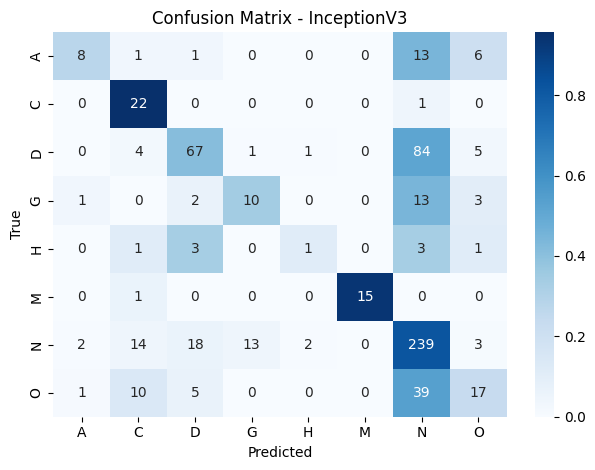

In [ ]:
cm = results['confusion_matrix']
cm_color = cm / np.sum(cm, axis=1, keepdims=True)
sns.heatmap(cm_color, annot=cm, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title(f'Confusion Matrix - InceptionV3')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

**GradCAM**

In [ ]:
pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

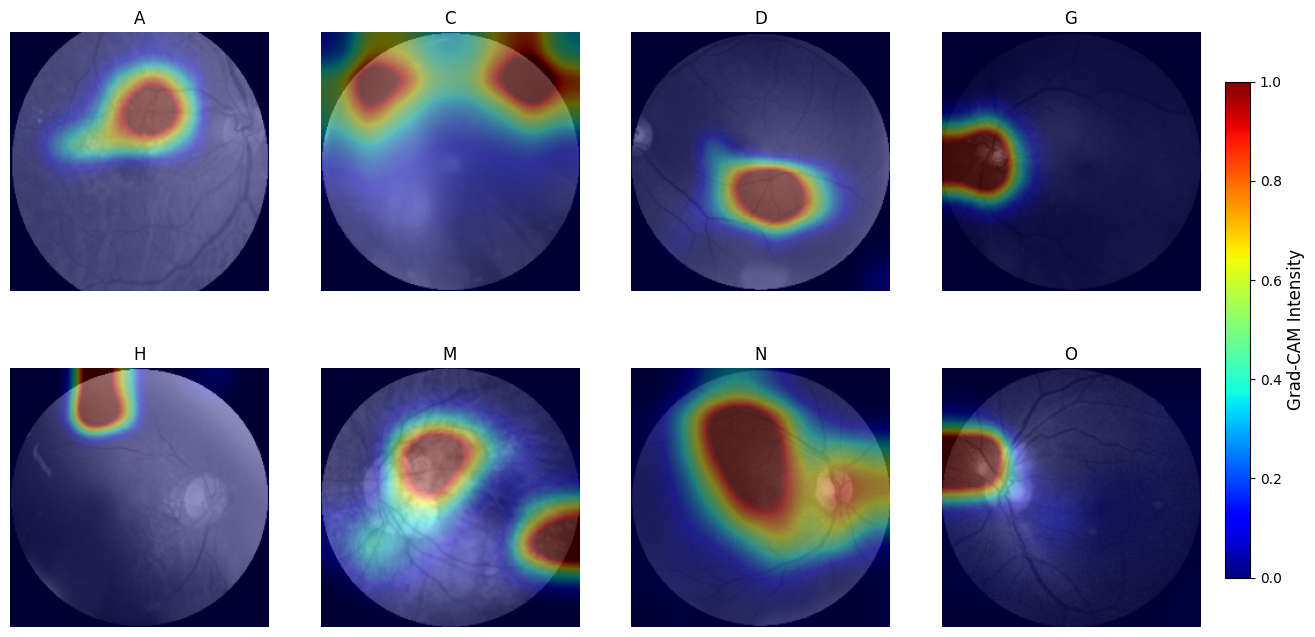

In [ ]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

random.seed(114513)

model = BaseModel(num_classes=num_classes, backbone=models.inception_v3(weights="DEFAULT")).to(device)
model.load_state_dict(torch.load(os.path.join(base_dir, "InceptionV3_best.pth")))

val_dataset = ImageSideDataset(val_dir, transform=val_transforms)

class_to_samples = {i: [] for i in range(len(classes))}
for img_path, _, label_idx in val_dataset.samples:
    class_to_samples[label_idx].append(img_path)

selected_samples = {
    label_idx: random.choice(img_list) for label_idx, img_list in class_to_samples.items()
}

cam_extractor = GradCAM(model, target_layer="backbone.Mixed_7c")
model.eval()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()

for i, (label_idx, img_path) in enumerate(selected_samples.items()):
    original = Image.open(img_path).convert('RGB')
    img_tensor = val_transforms(original).to(device)
    input_tensor = val_gpu_transforms(img_tensor).unsqueeze(0)
    out = model(input_tensor, None)
    cam = 1.2 * cam_extractor(class_idx=label_idx, scores=out)[0].cpu()
    gray = original.convert("L").convert("RGB")
    cam_img = to_pil_image(cam, mode="F")
    vis = overlay_mask(gray, cam_img, alpha=0.6)
    im = axes[i].imshow(cam_img, cmap="jet", vmin=0, vmax=1)  # Dummy imshow for colorbar
    axes[i].imshow(vis)
    axes[i].set_title(f"{classes[label_idx]}", fontsize=12)
    axes[i].axis("off")
cbar = fig.colorbar(im, ax=axes, location="right", fraction=0.02, pad=0.02)
cbar.set_label("Grad-CAM Intensity", fontsize=12)
plt.show()

**Using Side**

In [ ]:
model_classes = {
    'BaseModel': BaseModel,
    'DoubleBranchModel': DoubleBranchModel,
    'FlipModel': FlipModel
}

val_side_flags = [i[1] for i in val_dataset.samples]

results = {}

for name, model_cls in model_classes.items():
    early_stop_counter = 0
    best_val_acc = 0
    patience = 3
    model = model_cls(num_classes=num_classes, backbone=models.inception_v3(weights="DEFAULT")).to(device)
    optimizer = optimizer_cls(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = scheduler_cls(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=num_epochs)

    for epoch in range(num_epochs):
        loss = train(model, train_loader, criterion, optimizer, scheduler=None)
        val_gt, val_preds = validate(model, val_loader, device)
        val_acc = np.mean(val_preds == val_gt)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stop_counter = 0
            torch.save(model.state_dict(), os.path.join(base_dir, f"InceptionV3_best_{name}.pth"))
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break
    model.load_state_dict(torch.load(os.path.join(base_dir, f"InceptionV3_best_{name}.pth")))

    gt, preds = validate(model, val_loader, device)
    cm = confusion_matrix(gt, preds, labels=list(range(num_classes)))
    accs = {classes[i]: cm[i, i] / np.sum(cm[i]) if np.sum(cm[i]) > 0 else 0 for i in range(num_classes)}
    results[name] = {"confusion_matrix": cm, "per_class_acc": accs, "overall_acc": np.mean(preds == gt)}
    print(name, "ACC", results[name]["overall_acc"])
    for side_name, side_value in [('left', 0), ('right', 1)]:
        side_preds = preds[np.array(val_side_flags) == side_value]
        side_gt = gt[np.array(val_side_flags) == side_value]
        precision = precision_score(side_gt, side_preds, average='micro', zero_division=0)
        recall = recall_score(side_gt, side_preds, average='micro', zero_division=0)
        results[name][f"{side_name}_precision"] = precision
        results[name][f"{side_name}_recall"] = recall

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 162MB/s] 
100%|██████████| 140/140 [19:01<00:00,  8.15s/it]


Epoch 1/10, Loss: 1.6470, Val Acc: 0.5476


100%|██████████| 140/140 [02:13<00:00,  1.05it/s]


Epoch 2/10, Loss: 1.0424, Val Acc: 0.5725


100%|██████████| 140/140 [02:12<00:00,  1.05it/s]


Epoch 3/10, Loss: 0.6127, Val Acc: 0.5530


100%|██████████| 140/140 [02:12<00:00,  1.06it/s]


Epoch 4/10, Loss: 0.3368, Val Acc: 0.5733


100%|██████████| 140/140 [02:12<00:00,  1.05it/s]


Epoch 5/10, Loss: 0.2517, Val Acc: 0.5788


100%|██████████| 140/140 [02:12<00:00,  1.06it/s]


Epoch 6/10, Loss: 0.1787, Val Acc: 0.5476


100%|██████████| 140/140 [02:12<00:00,  1.06it/s]


Epoch 7/10, Loss: 0.1671, Val Acc: 0.5686


100%|██████████| 140/140 [02:13<00:00,  1.05it/s]


Epoch 8/10, Loss: 0.1542, Val Acc: 0.5601
Early stopping triggered.
BaseModel ACC 0.5787831513260531


100%|██████████| 140/140 [02:12<00:00,  1.06it/s]


Epoch 1/10, Loss: 1.6545, Val Acc: 0.5772


100%|██████████| 140/140 [02:12<00:00,  1.05it/s]


Epoch 2/10, Loss: 1.0743, Val Acc: 0.5499


100%|██████████| 140/140 [02:12<00:00,  1.06it/s]


Epoch 3/10, Loss: 0.6307, Val Acc: 0.5328


100%|██████████| 140/140 [02:12<00:00,  1.06it/s]


Epoch 4/10, Loss: 0.3555, Val Acc: 0.5780


100%|██████████| 140/140 [02:12<00:00,  1.05it/s]


Epoch 5/10, Loss: 0.2641, Val Acc: 0.5195


100%|██████████| 140/140 [02:12<00:00,  1.06it/s]


Epoch 6/10, Loss: 0.1796, Val Acc: 0.4743


100%|██████████| 140/140 [02:12<00:00,  1.05it/s]


Epoch 7/10, Loss: 0.1604, Val Acc: 0.5296
Early stopping triggered.
DoubleBranchModel ACC 0.578003120124805


100%|██████████| 140/140 [02:12<00:00,  1.05it/s]


Epoch 1/10, Loss: 1.5972, Val Acc: 0.5530


100%|██████████| 140/140 [02:13<00:00,  1.05it/s]


Epoch 2/10, Loss: 0.9866, Val Acc: 0.5569


100%|██████████| 140/140 [02:12<00:00,  1.06it/s]


Epoch 3/10, Loss: 0.5902, Val Acc: 0.5663


100%|██████████| 140/140 [02:13<00:00,  1.05it/s]


Epoch 4/10, Loss: 0.3190, Val Acc: 0.4524


100%|██████████| 140/140 [02:13<00:00,  1.05it/s]


Epoch 5/10, Loss: 0.2136, Val Acc: 0.5140


100%|██████████| 140/140 [02:12<00:00,  1.05it/s]


Epoch 6/10, Loss: 0.1841, Val Acc: 0.5686


100%|██████████| 140/140 [02:13<00:00,  1.05it/s]


Epoch 7/10, Loss: 0.1573, Val Acc: 0.5304


100%|██████████| 140/140 [02:12<00:00,  1.06it/s]


Epoch 8/10, Loss: 0.1062, Val Acc: 0.5655


100%|██████████| 140/140 [02:12<00:00,  1.05it/s]


Epoch 9/10, Loss: 0.1219, Val Acc: 0.5499
Early stopping triggered.
FlipModel ACC 0.5686427457098284


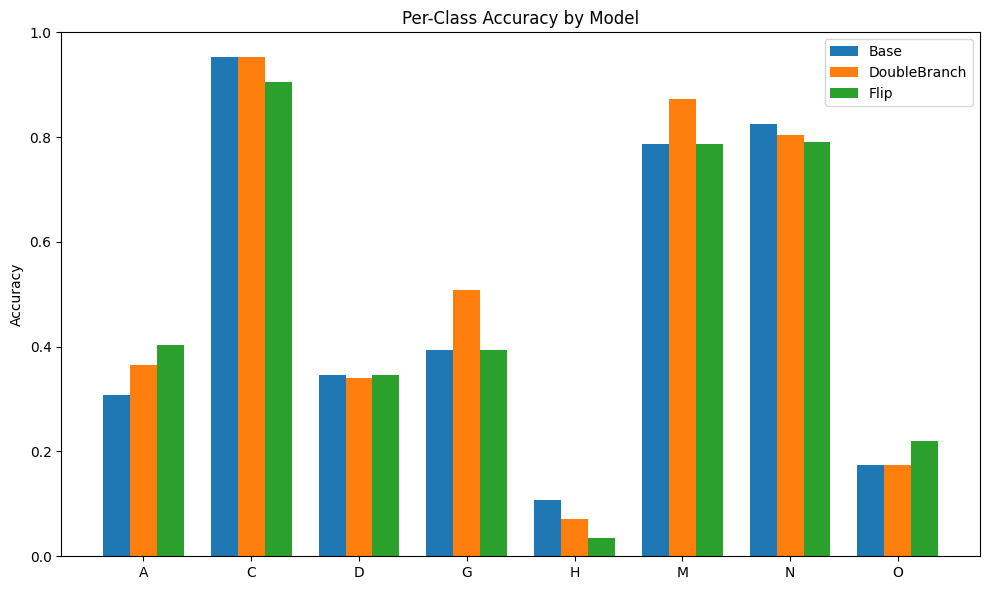

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(num_classes)
width = 0.25

acc_base = [results["BaseModel"]["per_class_acc"][cls] for cls in classes]
acc_double = [results["DoubleBranchModel"]["per_class_acc"][cls] for cls in classes]
acc_flip = [results["FlipModel"]["per_class_acc"][cls] for cls in classes]

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, acc_base, width, label='Base')
ax.bar(x, acc_double, width, label='DoubleBranch')
ax.bar(x + width, acc_flip, width, label='Flip')

ax.set_ylabel('Accuracy')
ax.set_title('Per-Class Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()

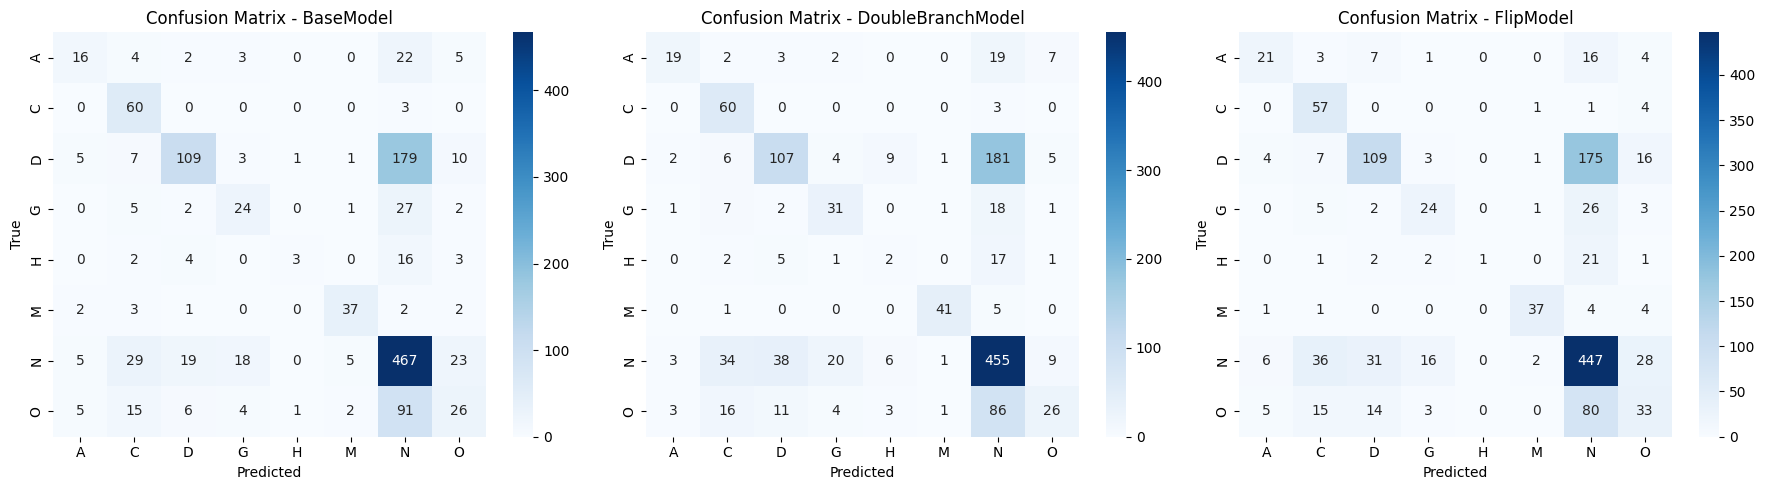

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
model_names = ['BaseModel', 'DoubleBranchModel', 'FlipModel']

for ax, name in zip(axes, model_names):
    cm = results[name]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=classes, yticklabels=classes)
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

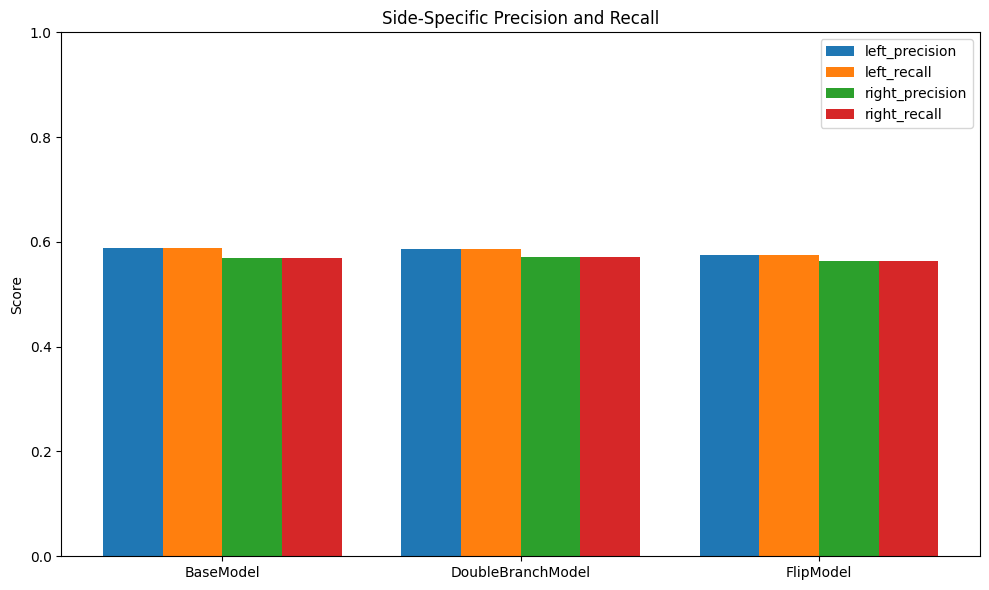

In [ ]:
models = list(results.keys())
metrics = ['left_precision', 'left_recall', 'right_precision', 'right_recall']

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

for i, m in enumerate(metrics):
    values = []
    for model in models:
        val = results[model][m]
        values.append(val)
    ax.bar(x + (i - 1.5) * width, values, width, label=m)

ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('Score')
ax.set_title("Side-Specific Precision and Recall")
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()